# 11-6. 프로젝트 : 폐렴 진단기 성능개선

조금 전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀 더 분발해야겠죠?

그렇다면 우리는 조금 전까지의 실습 과정을 되짚어보면서, 어떤 점을 더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 더 성능을 향상시켜 보려고 합니다.

## 목차

#### Step 0. 데이터셋을 불러오기
#### Step 1. 실험 환경 Set-up  
#### Step 2. 데이터 준비하기  
#### Step 3. 데이터 시각화  
#### Step 4. CNN 모델링  
#### Step 5. 데이터 imbalance 처리  
#### Step 6. 모델 훈련  
#### Step 7. 결과 확인과 시각화  
#### Step 8. 루브릭 & 회고

## Step 0. 데이터셋을 불러오기

#### 'Cloud shell'을 통해 프로젝트 디렉토리를 생성해 주신 후 데이터셋을 불러와주세요.

- mkdir -p ~/aiffel/chest_xray
- ln -s ~/data/ ~/aiffel/chest_xray

## Step 1. 실험 환경 Set-up

거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [1]:
# 라이브러리 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드 할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# BATCH_SIZE 변수
BATCH_SIZE = 10

# EPOCH 크기 변수 (16에서 10으로 변경)
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.

의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.

그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [3]:
# 주어진 패턴과 일치하는 파일 목록을 반환하는 tf.io.gfile.glob() 메서드를 활용합니다.
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터 별 개수 확인
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

- 개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

In [5]:
# 정상 이미지와 폐렴 이미지를 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0447-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person614_bacteria_2483.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다.

우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다.

데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다.

test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

tf.data 인스턴스를 만들어 봅시다.

tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.

이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.

decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. 

get_label을 이용해서 라벨 값을 가져옵니다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다.

num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줍니다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있음을 확인 할 수 있습니다.

참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 것을 의미입니다.

위에서 train과 validation 데이터셋을 만든 것처럼 이번에는 test 데이터셋도 만들어보겠습니다.

그리고 추가로 데이터 개수도 확인해보겠습니다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.

tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.

예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다. 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_basic = prepare_for_training(train_ds)
val_ds_basic = prepare_for_training(val_ds)

### augmentation

augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다. 그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training_aug(train_ds)
val_ds_aug = prepare_for_training_aug(val_ds)

## Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.

만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해

실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

### 3-1. 노드에서 진행한 데이터 시각화
---

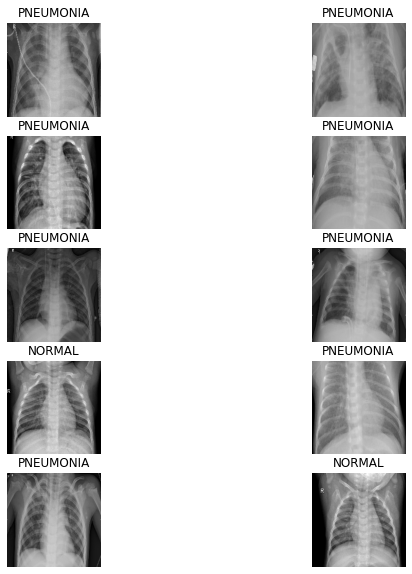

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_basic))
show_batch(image_batch.numpy(), label_batch.numpy())

### 3-2. augmentation를 시도한 데이터 시각화

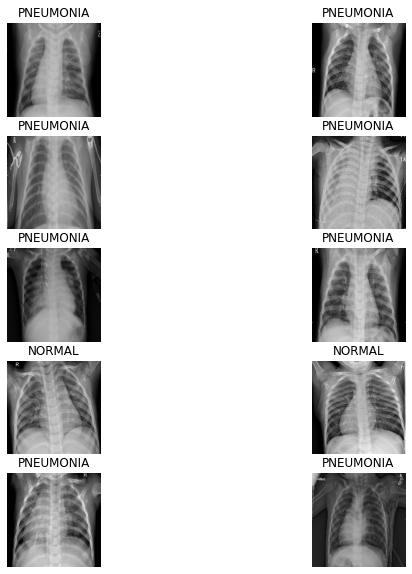

In [17]:
# train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다.

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch_aug, label_batch_aug = next(iter(train_ds_aug))
show_batch(image_batch_aug.numpy(), label_batch_aug.numpy())

## Step 4. CNN 모델링

의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다.

Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.

이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense Block 은 아래와 같이 만듭니다.

- 본인은 이번 11번 프로젝트 우수 노드 중 다양한 모델링을 사용한 github (https://github.com/sjeena0722/AIFFEL/blob/main/EXPLORATION/%5BE-11%5D%ED%8F%90%EB%A0%B4%EC%95%84_%EA%B8%B0%EB%8B%A4%EB%A0%A4%EB%9D%BC!.ipynb) 를 참고해서 모델링을 진행해 보았습니다.

#### 4-1. BatchNormalization & Dropout 둘 다 사용

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#### 4-2. BatchNormalization만 사용

In [20]:
def dense_block_B(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

#### 3. Dropout만 사용

In [21]:
def dense_block_D(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#### 4. BatchNormalization & Dropout 둘 다 사용 안 함

In [22]:
def dense_block_no(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
    ])
    
    return block

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.

어떤 부분이 가장 특이한가요? 눈에 띄셨을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다. 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다. 대표적으로 아래와 같은 논문의 사례를 들 수 있습니다.

위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다.

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.

In [23]:
# 4-1. BatchNormalization & Dropout 둘 다 사용
def build_model_1():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [24]:
# 4-2. BatchNormalization만 사용
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_B(512),
        dense_block_B(128),
        dense_block_B(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [25]:
# 4-3. Dropout만 사용
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_D(512, 0.7),
        dense_block_D(128, 0.5),
        dense_block_D(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [26]:
# 4-4. BatchNormalization & Dropout 둘 다 안 함
def build_model_4():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_no(512),
        dense_block_no(128),
        dense_block_no(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다.

만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

위에서 얘기했던 데이터 imbalance 문제입니다. 'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고합시다.

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다

In [27]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


- NORMAL 에서의 Weight는 1.95, PNEUMONIA 에서의 Weight 는 0.67 임을 확인 할 수 있습니다.

## Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

#### 6-1. 기존 모델

In [28]:
with tf.device('/GPU:0'):
    model = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)

In [29]:
# '조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 함
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 88s 146ms/step - loss: 0.5614 - accuracy: 0.7032 - precision: 0.9076 - recall: 0.6694 - val_loss: 1.2094 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 59s 141ms/step - loss: 0.3153 - accuracy: 0.8642 - precision: 0.9628 - recall: 0.8516 - val_loss: 0.7322 - val_accuracy: 0.7510 - val_precision: 1.0000 - val_recall: 0.6610
Epoch 3/10
418/418 [==============================] - 60s 143ms/step - loss: 0.2435 - accuracy: 0.9005 - precision: 0.9723 - recall: 0.8911 - val_loss: 0.1978 - val_accuracy: 0.9173 - val_precision: 0.9971 - val_recall: 0.8899
Epoch 4/10
418/418 [==============================] - 61s 146ms/step - loss: 0.1993 - accuracy: 0.9225 - precision: 0.9824 - recall: 0.9118 - val_loss: 0.0982 - val_accuracy: 0.9692 - val_precision: 0.9816 - val_recall: 0.9764
Epoch 5/10
418/418 [==============================] - 61s 146ms/step - loss: 0.2168 - accura

- 기존 모델로 훈련시킨 결과 : Epoch 10 중 6 에서 훈련이 early stopping 되었으며, 6회에서 loss: 0.2094 - accuracy: 0.9190 - precision: 0.9759 - recall: 0.9129 - val_loss: 0.2891 - val_accuracy: 0.8865 - val_precision: 0.9969 - val_recall: 0.8484 를 보임을 확인 할 수 있었습니다.

#### 6-2. 기존 모델 + augmentation

In [31]:
with tf.device('/GPU:0'):
    model_aug = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS, 시간상 줄임 원래는 위에 25
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 71s 144ms/step - loss: 0.7505 - accuracy: 0.6130 - precision: 0.8387 - recall: 0.5963 - val_loss: 0.6856 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 59s 141ms/step - loss: 0.3375 - accuracy: 0.8397 - precision: 0.9575 - recall: 0.8222 - val_loss: 0.1216 - val_accuracy: 0.9625 - val_precision: 0.9764 - val_recall: 0.9725
Epoch 3/10
418/418 [==============================] - 60s 144ms/step - loss: 0.2363 - accuracy: 0.8996 - precision: 0.9752 - recall: 0.8880 - val_loss: 0.2962 - val_accuracy: 0.8788 - val_precision: 0.9984 - val_recall: 0.8362
Epoch 4/10
418/418 [==============================] - 60s 144ms/step - loss: 0.2440 - accuracy: 0.9040 - precision: 0.9720 - recall: 0.8987 - val_loss: 0.2645 - val_accuracy: 0.8913 - val_precision: 0.9910 - val_recall: 0.8599
Epoch 00004: early stopping


- 기존 모델 + augmentation 로 훈련시킨 결과 : Epoch 10 중 4 에서 훈련이 early stopping 되었으며, 4회에서 loss: 0.2440 - accuracy: 0.9040 - precision: 0.9720 - recall: 0.8987 - val_loss: 0.2645 - val_accuracy: 0.8913 - val_precision: 0.9910 - val_recall: 0.8599 를 보임을 확인 할 수 있었습니다.

#### 6-3. BatchNormalization만 사용

In [33]:
with tf.device('/GPU:0'):
    model_B = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_B.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [34]:
with tf.device('/GPU:0'):
    history_B = model_B.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 71s 143ms/step - loss: 0.3917 - accuracy: 0.8155 - precision: 0.9558 - recall: 0.7918 - val_loss: 1.1127 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 60s 143ms/step - loss: 0.1939 - accuracy: 0.9229 - precision: 0.9767 - recall: 0.9189 - val_loss: 0.3677 - val_accuracy: 0.8596 - val_precision: 0.8405 - val_recall: 0.9987
Epoch 3/10
418/418 [==============================] - 60s 143ms/step - loss: 0.1877 - accuracy: 0.9301 - precision: 0.9779 - recall: 0.9276 - val_loss: 0.2737 - val_accuracy: 0.8856 - val_precision: 1.0000 - val_recall: 0.8444
Epoch 4/10
418/418 [==============================] - 61s 147ms/step - loss: 0.1560 - accuracy: 0.9338 - precision: 0.9822 - recall: 0.9288 - val_loss: 0.0919 - val_accuracy: 0.9654 - val_precision: 0.9777 - val_recall: 0.9751
Epoch 5/10
418/418 [==============================] - 63s 151ms/step - loss: 0.1323 - accura

- BatchNormalization만 사용해서 훈련시킨 결과 : Epoch 10 중 6 에서 훈련이 early stopping 되었으며, 6회에서 loss: 0.1098 - accuracy: 0.9615 - precision: 0.9900 - recall: 0.9578 - val_loss: 0.1142 - val_accuracy: 0.9500 - val_precision: 0.9986 - val_recall: 0.9333 를 보임을 확인 할 수 있었습니다.

#### 6-4. Dropout만 사용

In [35]:
with tf.device('/GPU:0'):
    model_D = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_D.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [36]:
with tf.device('/GPU:0'):
    history_D = model_D.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 70s 141ms/step - loss: 0.4613 - accuracy: 0.8109 - precision: 0.8939 - recall: 0.8544 - val_loss: 1.5059 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 59s 141ms/step - loss: 0.2541 - accuracy: 0.9024 - precision: 0.9746 - recall: 0.8916 - val_loss: 0.1710 - val_accuracy: 0.9240 - val_precision: 0.9153 - val_recall: 0.9882
Epoch 3/10
418/418 [==============================] - 59s 141ms/step - loss: 0.1919 - accuracy: 0.9224 - precision: 0.9786 - recall: 0.9158 - val_loss: 0.3631 - val_accuracy: 0.9077 - val_precision: 0.8902 - val_recall: 0.9974
Epoch 4/10
418/418 [==============================] - 61s 147ms/step - loss: 0.1600 - accuracy: 0.9364 - precision: 0.9858 - recall: 0.9276 - val_loss: 0.2694 - val_accuracy: 0.9010 - val_precision: 0.8831 - val_recall: 0.9974
Epoch 00004: early stopping


- Dropout만 사용해서 훈련시킨 결과 : Epoch 10 중 4 에서 훈련이 early stopping 되었으며, 4회에서 loss: 0.1600 - accuracy: 0.9364 - precision: 0.9858 - recall: 0.9276 - val_loss: 0.2694 - val_accuracy: 0.9010 - val_precision: 0.8831 - val_recall: 0.9974 를 보임을 확인 할 수 있었습니다.

#### 6-5. BatchNormalization & Dropout 둘 다 사용 안 함

In [37]:
with tf.device('/GPU:0'):
    model_no = build_model_4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [38]:
with tf.device('/GPU:0'):
    history_no = model_no.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 70s 141ms/step - loss: 0.4073 - accuracy: 0.7968 - precision: 0.9248 - recall: 0.7948 - val_loss: 0.8552 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 59s 141ms/step - loss: 0.1412 - accuracy: 0.9411 - precision: 0.9855 - recall: 0.9349 - val_loss: 0.2067 - val_accuracy: 0.9096 - val_precision: 0.8914 - val_recall: 0.9987
Epoch 3/10
418/418 [==============================] - 59s 141ms/step - loss: 0.1212 - accuracy: 0.9502 - precision: 0.9889 - recall: 0.9436 - val_loss: 1.0630 - val_accuracy: 0.8337 - val_precision: 0.8156 - val_recall: 1.0000
Epoch 4/10
418/418 [==============================] - 60s 144ms/step - loss: 0.1925 - accuracy: 0.9273 - precision: 0.9843 - recall: 0.9175 - val_loss: 0.0864 - val_accuracy: 0.9615 - val_precision: 0.9547 - val_recall: 0.9948
Epoch 5/10
418/418 [==============================] - 62s 149ms/step - loss: 0.0912 - accura

- BatchNormalization & Dropout 둘 다 사용 안하고 훈련시킨 결과 : Epoch 10 중 8 에서 훈련이 early stopping 되었으며, 8회에서 loss: 0.1063 - accuracy: 0.9603 - precision: 0.9875 - recall: 0.9586 - val_loss: 0.1123 - val_accuracy: 0.9587 - val_precision: 0.9945 - val_recall: 0.9491 를 보임을 확인 할 수 있었습니다.

#### 6-6. BatchNormalization & Dropout 둘 다 사용 안 함 + augmentation

In [39]:
with tf.device('/GPU:0'):
    model_no_aug = build_model_4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [40]:
with tf.device('/GPU:0'):
    history_no_aug = model_no_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 70s 142ms/step - loss: 0.4625 - accuracy: 0.7289 - precision: 0.9149 - recall: 0.6933 - val_loss: 1.7423 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 59s 142ms/step - loss: 0.1914 - accuracy: 0.9175 - precision: 0.9846 - recall: 0.9032 - val_loss: 0.2209 - val_accuracy: 0.9183 - val_precision: 0.9099 - val_recall: 0.9870
Epoch 3/10
418/418 [==============================] - 62s 148ms/step - loss: 0.1674 - accuracy: 0.9288 - precision: 0.9837 - recall: 0.9200 - val_loss: 0.1486 - val_accuracy: 0.9481 - val_precision: 0.9721 - val_recall: 0.9569
Epoch 4/10
418/418 [==============================] - 60s 143ms/step - loss: 0.1339 - accuracy: 0.9434 - precision: 0.9835 - recall: 0.9394 - val_loss: 0.1780 - val_accuracy: 0.9365 - val_precision: 0.9902 - val_recall: 0.9228
Epoch 5/10
418/418 [==============================] - 62s 147ms/step - loss: 0.1276 - accura

- BatchNormalization & Dropout 둘 다 사용 안 함 + augmentation 으로 훈련시킨 결과 : Epoch 10 중 5 에서 훈련이 early stopping 되었으며, 5회에서 loss: 0.1276 - accuracy: 0.9464 - precision: 0.9881 - recall: 0.9396 - val_loss: 0.2055 - val_accuracy: 0.9481 - val_precision: 0.9450 - val_recall: 0.9869 를 보임을 확인 할 수 있었습니다.

#### 6-7. BatchNormalization만 사용 + augmentation

In [41]:
with tf.device('/GPU:0'):
    model_B_aug = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_B_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [42]:
with tf.device('/GPU:0'):
    history_B_aug = model_B_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 72s 145ms/step - loss: 0.3863 - accuracy: 0.8296 - precision: 0.9549 - recall: 0.8058 - val_loss: 0.8863 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 60s 145ms/step - loss: 0.2342 - accuracy: 0.9079 - precision: 0.9695 - recall: 0.9050 - val_loss: 0.1454 - val_accuracy: 0.9519 - val_precision: 0.9509 - val_recall: 0.9856
Epoch 3/10
418/418 [==============================] - 61s 145ms/step - loss: 0.2006 - accuracy: 0.9185 - precision: 0.9736 - recall: 0.9157 - val_loss: 0.1258 - val_accuracy: 0.9481 - val_precision: 0.9917 - val_recall: 0.9374
Epoch 4/10
418/418 [==============================] - 61s 146ms/step - loss: 0.1655 - accuracy: 0.9357 - precision: 0.9845 - recall: 0.9280 - val_loss: 0.2146 - val_accuracy: 0.9192 - val_precision: 0.9956 - val_recall: 0.8941
Epoch 5/10
418/418 [==============================] - 63s 150ms/step - loss: 0.1564 - accura

- BatchNormalization만 사용 + augmentation 으로 훈련시킨 결과 : Epoch 10 중 5 에서 훈련이 early stopping 되었으며, 5회에서 loss: 0.1564 - accuracy: 0.9419 - precision: 0.9827 - recall: 0.9379 - val_loss: 0.2637 - val_accuracy: 0.8875 - val_precision: 0.9954 - val_recall: 0.8510 를 보임을 확인 할 수 있었습니다.

#### 6-8. Dropout만 사용 + augmentation

In [43]:
with tf.device('/GPU:0'):
    model_D_aug = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_D_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
with tf.device('/GPU:0'):
    history_D_aug = model_D_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 71s 144ms/step - loss: 0.4874 - accuracy: 0.7553 - precision: 0.8837 - recall: 0.7556 - val_loss: 0.8331 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 60s 144ms/step - loss: 0.2464 - accuracy: 0.8958 - precision: 0.9742 - recall: 0.8849 - val_loss: 0.1912 - val_accuracy: 0.9240 - val_precision: 0.9134 - val_recall: 0.9909
Epoch 3/10
418/418 [==============================] - 60s 144ms/step - loss: 0.2139 - accuracy: 0.9142 - precision: 0.9805 - recall: 0.9022 - val_loss: 0.3356 - val_accuracy: 0.8663 - val_precision: 0.9984 - val_recall: 0.8194
Epoch 4/10
418/418 [==============================] - 60s 143ms/step - loss: 0.1910 - accuracy: 0.9266 - precision: 0.9839 - recall: 0.9176 - val_loss: 0.2581 - val_accuracy: 0.8962 - val_precision: 0.9985 - val_recall: 0.8599
Epoch 00004: early stopping


- Dropout만 사용 + augmentation 으로 훈련시킨 결과 : Epoch 10 중 4 에서 훈련이 early stopping 되었으며, 4회에서 loss: 0.1910 - accuracy: 0.9266 - precision: 0.9839 - recall: 0.9176 - val_loss: 0.2581 - val_accuracy: 0.8962 - val_precision: 0.9985 - val_recall: 0.8599를 보임을 확인 할 수 있었습니다.

## Step 7. 결과 확인과 시각화

테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다.

훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

### 7-1. 시각화 진행

- 위에서 훈련한 데이터를 기반으로 'precision', 'recall', 'accuracy', 'loss'을 기준으로 시각화를 진행 보았습니다.

#### 7-1-1. 기존 모델

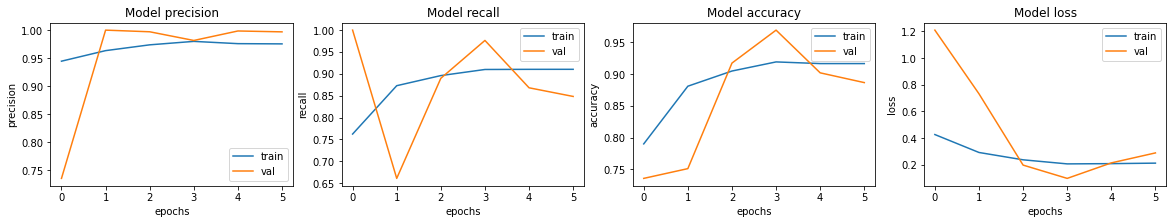

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 7-1-2. 기존 모델 + augmentation

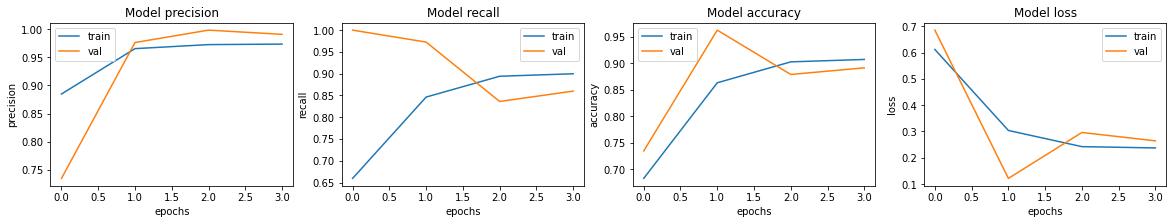

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 7-1-3. BatchNormalization만 사용

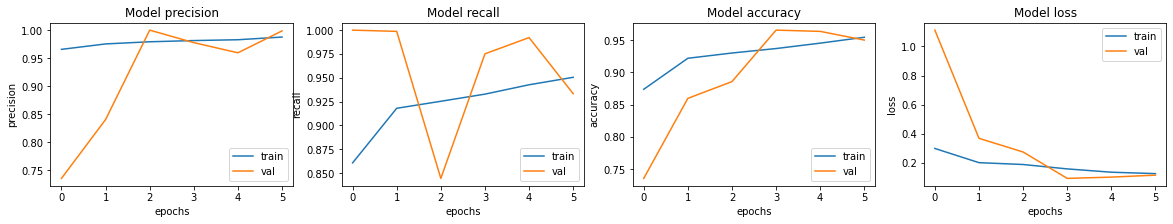

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_B.history[met])
    ax[i].plot(history_B.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 7-1-4. Dropout만 사용

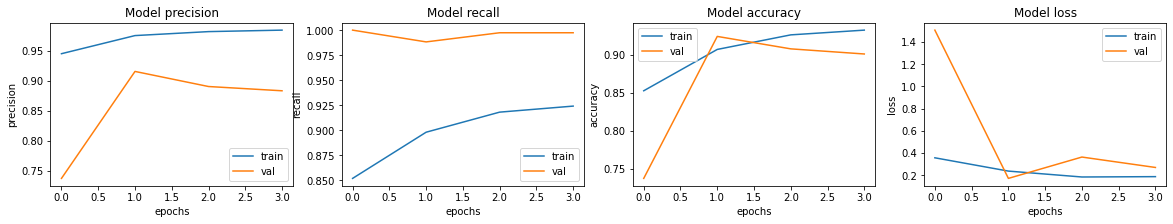

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_D.history[met])
    ax[i].plot(history_D.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 7-1-5. BatchNormalization & Dropout 둘 다 사용 안 함

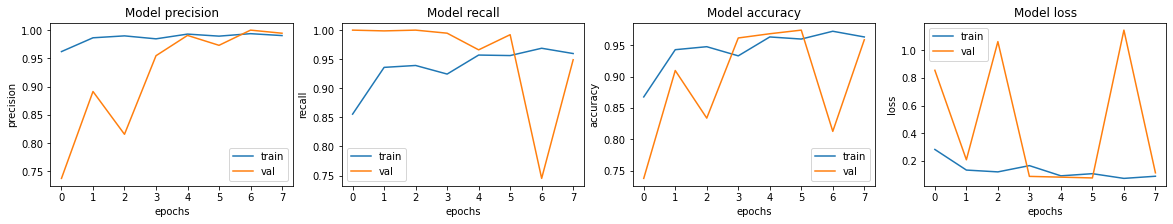

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no.history[met])
    ax[i].plot(history_no.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 7-1-6. BatchNormalization & Dropout 둘 다 사용 안 함 + augmentation

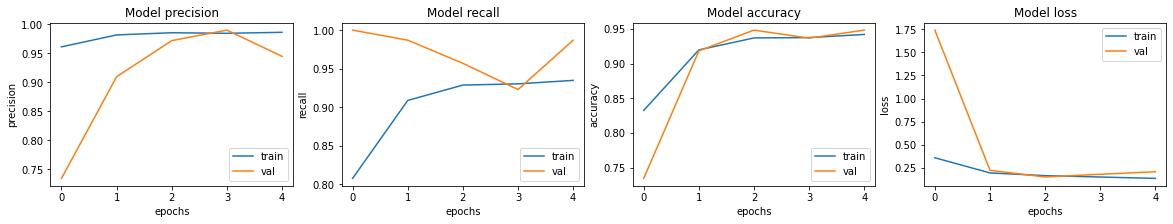

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_aug.history[met])
    ax[i].plot(history_no_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 7-1-7. BatchNormalization만 사용 + augmentation

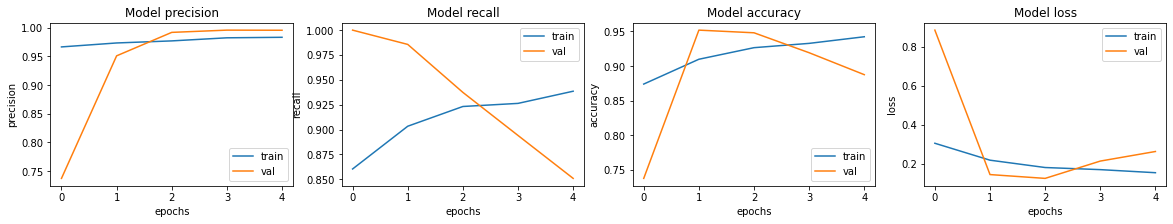

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_B_aug.history[met])
    ax[i].plot(history_B_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 7-1-8. Dropout만 사용 + augmentation

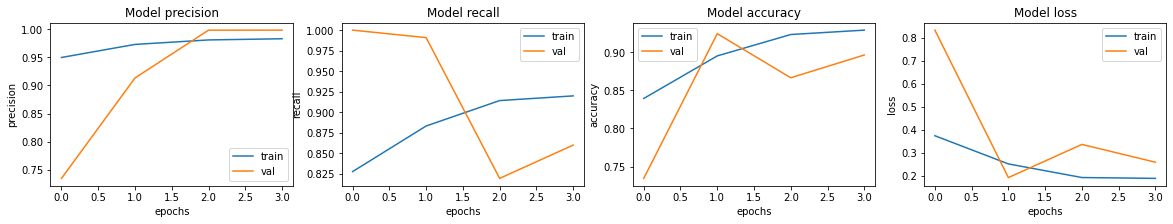

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_D_aug.history[met])
    ax[i].plot(history_D_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7-2. 테스트 데이터로 모델 평가

테스트 데이터로 모델 평가를 해보겠습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

#### 7-2-1. 기존 모델

In [54]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 24s 376ms/step - loss: 0.3604 - accuracy: 0.8846 - precision: 0.9015 - recall: 0.9154
Loss: 0.3604303300380707,
Accuracy: 0.8846153616905212,
Precision: 0.9015151262283325,
Recall: 0.9153845906257629


#### 7-2-2. 기존 모델 + augmentation

In [55]:
loss, accuracy, precision, recall = model_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 89ms/step - loss: 0.3442 - accuracy: 0.8750 - precision: 0.9021 - recall: 0.8974
Loss: 0.3441717326641083,
Accuracy: 0.875,
Precision: 0.9020618796348572,
Recall: 0.8974359035491943


#### 7-2-3. BatchNormalization만 사용

In [56]:
loss, accuracy, precision, recall = model_B.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 89ms/step - loss: 0.5522 - accuracy: 0.8397 - precision: 0.8098 - recall: 0.9718
Loss: 0.5522394180297852,
Accuracy: 0.8397436141967773,
Precision: 0.80982905626297,
Recall: 0.971794843673706


#### 7-2-4. Dropout만 사용

In [57]:
loss, accuracy, precision, recall = model_D.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 91ms/step - loss: 1.7255 - accuracy: 0.6635 - precision: 0.6500 - recall: 1.0000
Loss: 1.7255274057388306,
Accuracy: 0.6634615659713745,
Precision: 0.6499999761581421,
Recall: 1.0


#### 7-2-5. BatchNormalization & Dropout 둘 다 사용 안 함

In [58]:
loss, accuracy, precision, recall = model_no.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 89ms/step - loss: 2.2973 - accuracy: 0.8301 - precision: 0.7958 - recall: 0.9795
Loss: 2.2972636222839355,
Accuracy: 0.8301281929016113,
Precision: 0.7958333492279053,
Recall: 0.9794871807098389


#### 7-2-6. BatchNormalization & Dropout 둘 다 없음 + augmentation

In [59]:
loss, accuracy, precision, recall = model_no_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 88ms/step - loss: 3.5008 - accuracy: 0.7003 - precision: 0.6759 - recall: 1.0000
Loss: 3.5007641315460205,
Accuracy: 0.7003205418586731,
Precision: 0.6759098768234253,
Recall: 1.0


#### 7-2-7. BatchNormalization만 사용 + augmentation

In [60]:
loss, accuracy, precision, recall = model_B_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 89ms/step - loss: 0.3506 - accuracy: 0.8894 - precision: 0.9126 - recall: 0.9103
Loss: 0.3506004214286804,
Accuracy: 0.8894230723381042,
Precision: 0.9125964045524597,
Recall: 0.9102563858032227


#### 7-2-8. Dropout만 사용 + augmentation

In [61]:
loss, accuracy, precision, recall = model_D_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 89ms/step - loss: 0.4402 - accuracy: 0.7853 - precision: 0.7936 - recall: 0.8872
Loss: 0.4401596784591675,
Accuracy: 0.7852563858032227,
Precision: 0.7935779690742493,
Recall: 0.8871794939041138


- 테스트 모델로 평가를 진행해본 결과:

기존 모델
Accuracy: 0.8846153616905212

기존 모델 + augmentation 
Accuracy: 0.875

BatchNormalization만 사용
Accuracy: 0.8397436141967773

Dropout만 사용
Accuracy: 0.6634615659713745

BatchNormalization & Dropout 둘 다 사용 안 함
Accuracy: 0.8301281929016113

BatchNormalization & Dropout 둘 다 없음 + augmentation
Accuracy: 0.7003205418586731

BatchNormalization만 + augmentation
Accuracy: 0.8894230723381042

Dropout만 + augmentation
Accuracy: 0.7852563858032227

라는 결과를 돌출할 수 있었으며

기존 모델, 기존 모델 + augmentation, BatchNormalization만 사용 + augmentation 에서 목표로 했었던 Accuracy 기준 85% 이상의 값이 나왔지만

프로젝트를 진행하기 전 노드를 진행할 당시에 
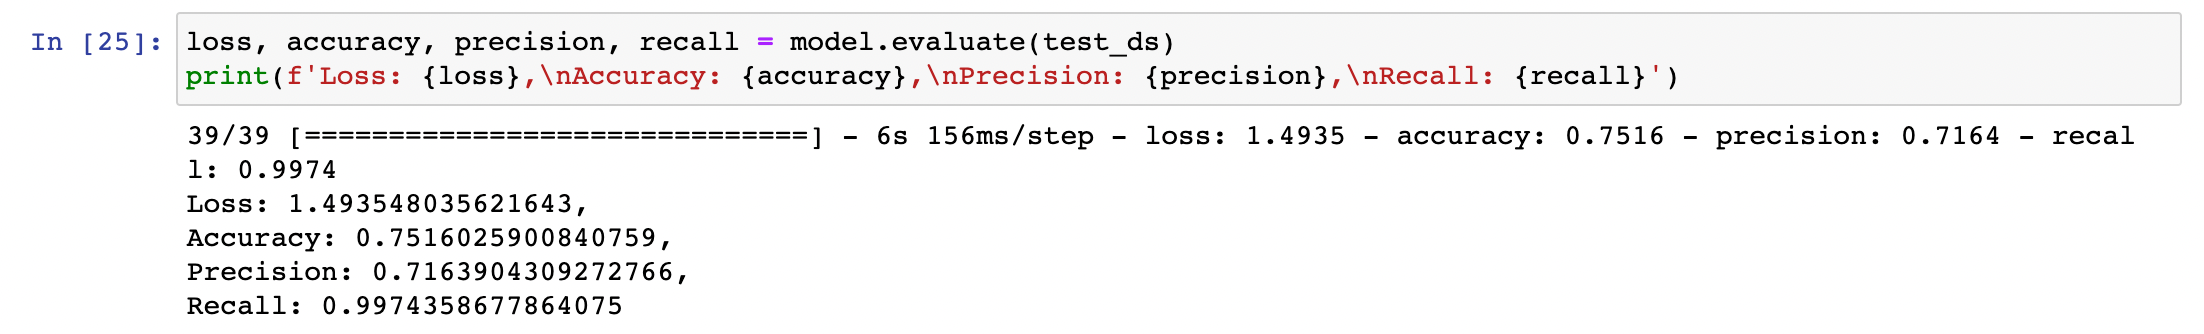

위와 같은 Accuracy: 0.7516025900840759 값이 나왔던 것을 보면 기존 모델, 기존 모델 + augmentation에선 과적합이 의심이 됩니다.

아마도 BatchNormalization만 사용하고 + augmentation 한 모델에서 Accuracy 기준 85% 이상의 값이 나온 것이 아닐까? 라는 생각을 합니다.

# Step 8. 루브릭 & 회고

## 루브릭

||평가문항|상세기준|
|:---|:---:|:---:|
|1|의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2|데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3|실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

## 회고


1. 처음에 홀로 시도를 했을 때, 노드에 나온 것과 augmentation 를 결함 시키는 것 말고는 생각이 나지 않아서, 우수 노드를 참고해서 진행을 해 보았습니다.

2. 다양한 모델링을 진행해서 학습을 진행해본 결과 epoch 4~8 내외로 학습이 끝나서 초기에 설정했었던 25 -> 10회로 수정을 하였습니다.

3. 또한 모델 평과 과정에서 기존 모델, 기존 모델 + augmentation, BatchNormalization만 사용 + augmentation 에서 목표로 했었던 Accuracy 기준 85% 이상의 값이 나왔지만, 프로젝트 진행 전 약 75% 가량의 Accuracy를 보였던 것을 보면 기존 모델이 과적합이 된 것이 아닐까? 라는 의심을 하였습니다.

4. 또한, 의료 데이터에서는 Accuracy 외에 recall까지 신경을 써야할텐데 평가 요소에 없는 것이 조금 아쉬웠습니다.

### 참고 레퍼런스

https://github.com/sjeena0722/AIFFEL/blob/main/EXPLORATION/%5BE-11%5D%ED%8F%90%EB%A0%B4%EC%95%84_%EA%B8%B0%EB%8B%A4%EB%A0%A4%EB%9D%BC!.ipynb